In [97]:
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import PIL

In [98]:
# import os
# from google.colab import files
# uploaded = files.upload()
# dst ='image.jpg' 
# os.rename(list(uploaded.keys())[0], dst)

In [99]:
# import os
# from google.colab import files
# uploaded = files.upload()
# dst ='movie.mp4' 
# os.rename(list(uploaded.keys())[0], dst)

In [100]:
resnet = resnet18(pretrained=False)
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch


In [ ]:
crnn = torch.load('crnn.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
crnn.to(device)

In [169]:
# damage colors(BGR)
elementColors = dict()
elementColors['anemo'] = (208, 255, 120)
elementColors['geo'] = (105, 198, 243)
elementColors['electro'] = (255, 139, 222)
elementColors['physical'] = (255, 255, 255)
elementColors['pyro'] = (0, 158, 243)
elementColors['cyro'] = (255, 255, 164)
elementColors['hydro'] = (251, 216, 63)
elementColorHSV = dict()
elementColorHSV['anemo'] = (255, 146, 80)
elementColorHSV['geo'] = (255, 146, 19)
elementColorHSV['electro'] = (255, 139, 222)
elementColorHSV['physical'] = (255, 255, 255)
elementColorHSV['pyro'] = (0, 158, 243)
elementColorHSV['cyro'] = (255, 255, 164)
elementColorHSV['hydro'] = (251, 216, 63)

resizeScale = 0.5
colorKey = "cyro"

In [170]:
def rectangleScaled(im, start, end, color, thickness=1):
    start = (int(start[0] / resizeScale), int(start[1] / resizeScale))
    end = (int(end[0] / resizeScale), int(end[1] / resizeScale))
    cv2.rectangle(im, start, end, color, thickness)

def restoreRectangle(rect):
    return (int(rect[0] / resizeScale), int(rect[1] / resizeScale), int(rect[2] / resizeScale), int(rect[3] / resizeScale))

In [104]:
templates = []
for i in range(10):
  templates.append(cv2.resize(cv2.imread('./templates/' + str(i) + '.png', 0), (36, 36)))

def matchingNumber(im):
  maxVal_All = 999999999999999
  num_dsp = 0
  resizedIm = cv2.resize(im, (36, 36))
  for i in range(10):

    result= abs(resizedIm - templates[i]).sum() # cv2.matchTemplate(resizedIm,templates[i],cv2.TM_CCOEFF_NORMED)
    # mmr=cv2.minMaxLoc(result)
    maxVal=result
    
    if maxVal < maxVal_All:
        num_dsp = i
        maxVal_All = maxVal
    
  return num_dsp
            


In [171]:
idx2char = {0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: 'x'}

def transform(image):
  transform_ops = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  ])
  return transform_ops(image)
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

def createDataset(original, resized, rect):
  global imageCounter
  x, y, w, h = restoreRectangle(rect)
  height = 150
  scale = height / h
  partImage = cv2.resize(original[y:y+h, x:x+w, :], (200, 50))
  
  rangeW = 20
  color = elementColors[colorKey]
  partImage = cv2.inRange(partImage, (max(color[0] - rangeW, 0), max(color[1] - rangeW, 0), max(color[2] - rangeW, 0)), (min(255, color[0] + rangeW), min(255, color[1] + rangeW), min(255, color[2] + rangeW)))

  partImage = cv2.cvtColor(partImage, cv2.COLOR_BGR2RGB)
  partImage = PIL.Image.fromarray(partImage)
  partImage = transform(partImage)


  # closing = cv2.dilate(partImage,(2, 2),iterations = 1)
  # thresh = cv2.adaptiveThreshold(closing, 255, 1, 1, 5, 2)
  # contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # if len(contours) < 4:
  #   return 0
  # lists = []
  # for cnt in contours:
  #   nextRect = cv2.boundingRect(cnt)
  #   x2, y2, w2, h2 = nextRect
  #   if h2 < 0.8 * height or w2 / h2 > 1:
  #     continue
  #   red = (255, 0, 0)
  #   # cv2.imwrite("./output/{}.png".format(imageCounter), closing[y2:y2+h2,x2:x2+w2])
  #   num = matchingNumber(closing[y2:y2+h2,x2:x2+w2])
  #   lists.append((num, x2))
  #   imageCounter += 1
  #   cv2.rectangle(original, (x + int(x2 / scale), y + int(y2 / scale)), (x + int((x2 + w2) / scale), y + int((y2 + h2) / scale)), red, 2)
  
  # lists.sort(key=lambda x: -x[1])
  # total = 0
  # for i, value in enumerate(lists):
  #   total += value[0] * (10 ** i) 
  return partImage

In [172]:
imageCounter = 0
def outputNumberBinaryImage(im, rect):
  global imageCounter
  x,y,w,h = rect
  outputImage = im[y:y+h, x:x+w]
  closing = cv2.dilate(outputImage,(4, 4),iterations = 1)
  cv2.imwrite("./output/{}_{}.png".format(colorKey, imageCounter), closing)
  imageCounter += 1

In [179]:


def drawContours(im, resized, parcent, width, height):
  
  rangeW = 20
  color = elementColors[colorKey]
  inrange = cv2.inRange(resized, (max(color[0] - rangeW, 0), max(color[1] - rangeW, 0), max(color[2] - rangeW, 0)), (min(255, color[0] + rangeW), min(255, color[1] + rangeW), min(255, color[2] + rangeW)))
  # for key, color in elementColors.items():
  #   nextInrange = cv2.inRange(im, (color[0] - rangeW, color[1] - rangeW, color[2] - rangeW), (color[0] + rangeW, color[1] + rangeW, color[2] + rangeW))
  #   inrange = np.maximum(nextInrange, inrange)

  # blur = cv2.GaussianBlur(inrange, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(inrange, 255, 1, 1, 7, 2)

  contours, _ = cv2.findContours(
      thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  framePos = []
  frameDataset = []

  inrange = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)

  red = (0, 0, 255)

  for cnt in contours:
    rect = cv2.boundingRect(cnt.astype(np.int32))
    x, y, w, h = rect
    

    if h < 20 or w / (h * 0.8) < 3:
      continue
    # flag = False
    # for px, py in prevFrameContours:
    #   if abs(px - (x + w / 2)) < 50 and abs(py - (y - h / 2)) < 50:
    #     flag = True
    #     break
    # if flag:
    #   continue
    
    # outputNumberBinaryImage(inrange, rect)
    cv2.rectangle(im, (x, y), (x + w, y + h), red, 2)
    framePos.append((x, y, w, h))
    frameDataset.append(createDataset(im, resized, rect))
  
  if len(frameDataset) > 0:
    frameDataset = torch.stack(frameDataset)
    frameDataset = frameDataset.to(device)
    pred = decode_predictions(crnn(frameDataset).cpu())
    for i in range(len(frameDataset)):
      x, y, w, h = framePos[i]
      try:
        numText = correct_prediction(pred[i]) 
        int(numText)
        # cv2.putText(im, numText, (int((x + w/2) / resizeScale), int((y+h * 2) / resizeScale)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 5)
        cv2.putText(im, numText, (int(x + w/2), int((y+h * 2))), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0, 0), 2)
        cv2.putText(im, numText, (20, 50 * i), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0, 0), 2)
      except ValueError:
        None
  return im

In [203]:
filename = "xiao2"
cap = cv2.VideoCapture('./{}.mp4'.format(filename))
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./{}_output.mp4'.format(filename), fourcc, frame_rate, (width, height))
colorKey = "anemo"
prevFrameNumber = []
import queue
textQueue = queue.Queue()

count = 0
imageCounter = 0

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

store_frame = None

while(cap.isOpened()):
  ret, frame = cap.read()
  count += 1
  if count % 24 == 0:
    print(count / frame_count * 100, '%')
  if (not(ret)):
    break
  
  color = elementColors[colorKey]
  rangeW = 20
  resized = cv2.resize(frame, (int(frame.shape[1] * resizeScale), int(frame.shape[0] * resizeScale)))
  res = drawContours(frame, resized, count / frame_count, frame.shape[1], frame.shape[0])

    
  # inrange = cv2.inRange(resized, (max(color[0] - rangeW, 0), max(color[1] - rangeW, 0), max(color[2] - rangeW, 0)), (min(255, color[0] + rangeW), min(255, color[1] + rangeW), min(255, color[2] + rangeW)))
  # # for key, color in elementColors.items():
  # #   nextInrange = cv2.inRange(im, (color[0] - rangeW, color[1] - rangeW, color[2] - rangeW), (color[0] + rangeW, color[1] + rangeW, color[2] + rangeW))
  # #   inrange = np.maximum(nextInrange, inrange)

  # # blur = cv2.GaussianBlur(inrange, (5, 5), 0)
  # res = cv2.adaptiveThreshold(inrange, 255, 1, 1, 7, 2)

  # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # out.write(res)
  cv2.imshow("frame", res)
  # cv2.imshow("frame", inrange)
  
  if cv2.waitKey(1) & 0xFF == ord('q'):
    store_frame = frame
    break

# out.release()
cap.release()
cv2.destroyAllWindows()
    


0.5389624971929037 %
1.0779249943858074 %
1.6168874915787108 %
2.1558499887716147 %
2.694812485964518 %
3.2337749831574216 %
3.772737480350326 %
4.311699977543229 %
4.850662474736133 %
5.389624971929036 %
5.928587469121941 %
6.467549966314843 %
7.006512463507747 %


In [188]:
cv2.imwrite(f"{filename}_output.png", store_frame)

True

[255 146  27]


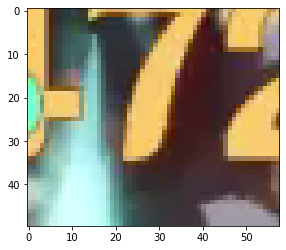

In [219]:
plt.imshow(store_frame[450:500, 1142:1200, ::-1])
print(cv2.cvtColor(store_frame, cv2.COLOR_BGR2HSV_FULL)[450, 1142, ::-1])